In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import zconfint
from scipy import stats
import scipy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv("./credit_card_default_analysis.csv")

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


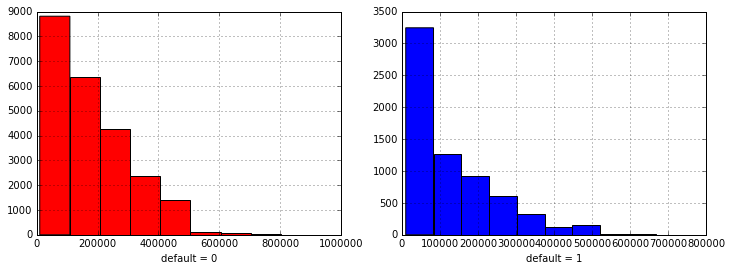

In [5]:
# Для начала посмотрим на распределения глазами
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(data[data.default==0].LIMIT_BAL, color = 'r')
pylab.xlabel('default = 0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(data[data.default==1].LIMIT_BAL, color = 'b')
pylab.xlabel('default = 1')

pylab.show()

In [6]:
# Заметно, что записей с default=0 больше, чем default=1.
# Видно, что распределения отличаются, но сделать выводов о медианах по графикам не представляется возможным

In [7]:
# 1 Размер кредитного лиимита
# a) равенство медианных значений кредитного лимита
# Гипотеза H0 будет утверждать, что медианы двух выборок совпадают
# Гипотеза H1: медианы двух выборок не совпадают
# Доверительный интервал для медианы определяется порядковыми статистиками, размеры обеих выборок > 50
# Положим alpha = 0.05, тогда k = 1/2(n - 1.96*sqrt(n) - 1)
# а медиана x(k) <= m < x(n - k + 1)
def calc_k(n):
    return 1. / 2 * (n - 1.96*np.sqrt(n) - 1)
    
def median_confint(col):
    n = len(col)
    k = int(calc_k(n))
    srt = sorted(col)
    return [srt[k], srt[n - k + 1]]
    
print median_confint(data[data.default==0].LIMIT_BAL)
print median_confint(data[data.default==1].LIMIT_BAL)

[150000, 150000]
[80000, 90000]


In [8]:
# Видно, что доверительные интервалы для медиан не пересекаются, следовательно можно отвергнуть нулевую гипотезу

In [9]:
# Можно попробовать посчитать медиану через бутстреп:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

def0_scores = map(np.median, get_bootstrap_samples(data[data.default==0].LIMIT_BAL.values, 1000))
def1_scores = map(np.median, get_bootstrap_samples(data[data.default==1].LIMIT_BAL.values, 1000))

print "95% confidence interval for default = 0 credit limit:",  stat_intervals(def0_scores, 0.05)
print "95% confidence interval for default = 1 credit limit:",  stat_intervals(def1_scores, 0.05)

95% confidence interval for default = 0 credit limit: [ 150000.  150000.]
95% confidence interval for default = 1 credit limit: [ 80000.  90000.]


In [10]:
# Как видно, результат не изменился, нулевая гипотеза отвергается и при использовании этого способа

In [11]:
# b) равенство распределений
# Выборки независимы, будем использовать ранговый критерий Манна-Уитни 
# X — выборка data[data.default==0].LIMIT_BAL
# Y — выборка data[data.default==1].LIMIT_BAL
# H0 — P(X>Y) = 1/2
# H1 — P(X>Y) != 1/2
# alpha — 0.05

stats.mannwhitneyu(data[data.default==0].LIMIT_BAL, data[data.default==1].LIMIT_BAL)

MannwhitneyuResult(statistic=95786286.5, pvalue=3.4348973226457305e-189)

In [12]:
# уровень значимости существенно меньше 0.05, что позволяет нам отвергнуть нулевую гипотезу о том, что средние двух выборок равны
# Мы видим, что кредитный лимит людей, не вернувших денежные средства, существенно меньше (более чем в полтора раза),
# чем кредитный лимит людей, возвратившых средства. На мой взгляд это имеет практическую значимость.

In [13]:
# 2 Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается.
# Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

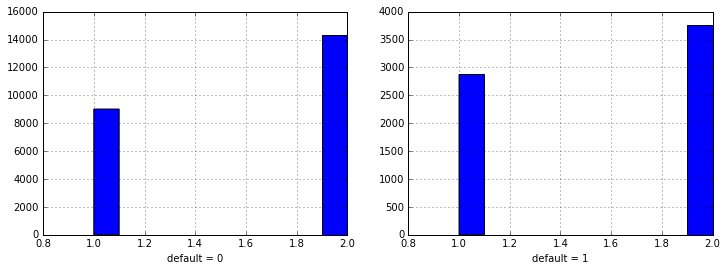

In [14]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(data[data.default==0].SEX)
pylab.xlabel('default = 0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(data[data.default==1].SEX)
pylab.xlabel('default = 1')

pylab.show()

In [15]:
# На первый взгяд кажется, что среди людей, вернувших кредит, доля женщин больше, чем в группе людей кредит не вернувших.

In [16]:
# X — доля женщин в выборке default=0
# Y — доля женщин в выборке default=1
# Гипотеза H0: X = Y
# Гипотеза H1: X != Y

# Для начала примений Z-критерий для разности долей двух независимых выборок
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [17]:
p = proportions_diff_z_test(proportions_diff_z_stat_ind(data[data.default==0].SEX - 1, data[data.default==1].SEX - 1))
print p

4.47286652161e-12


In [18]:
# при alpha=0.05 нулевая гипотеза о равенстве долей женщин в двух выборок может быть отвергнута

In [19]:
# теперь протестируем те же гипотезы с помощью интервальной оценки
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [20]:
proportions_diff_confint_ind(data[data.default==0].SEX - 1, data[data.default==1].SEX - 1)

(0.033634932749628671, 0.060548077974896725)

In [21]:
s1 = data[data.default==0].SEX - 1
s2 = data[data.default==1].SEX - 1
float(sum(s2)) / len(s2) - float(sum(s1)) / len(s1)
# как мы видим, 0 не входит в доверительный интервал, а значит мы можем отвергнуть нулевую гипотезу с уровнем значимости 0.05
# данный результат имеют практическую значимость, которая заключается в том,
# что женщины более склонны к выполнению своих обязательств — почти на 5%

-0.0470915053622627

In [22]:
# 3. Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.
data.EDUCATION.unique()

array([2, 1, 3, 5, 4, 6, 0])

In [23]:
data[data.default==0].groupby(by='EDUCATION').count()

,ID,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
EDUCATION,,,,,,,,,,,,,,,,,,,,,
0,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
1,8549,8549,8549,8549,8549,8549,8549,8549,8549,8549,...,8549,8549,8549,8549,8549,8549,8549,8549,8549,8549
2,10700,10700,10700,10700,10700,10700,10700,10700,10700,10700,...,10700,10700,10700,10700,10700,10700,10700,10700,10700,10700
3,3680,3680,3680,3680,3680,3680,3680,3680,3680,3680,...,3680,3680,3680,3680,3680,3680,3680,3680,3680,3680
4,116,116,116,116,116,116,116,116,116,116,...,116,116,116,116,116,116,116,116,116,116
5,262,262,262,262,262,262,262,262,262,262,...,262,262,262,262,262,262,262,262,262,262
6,43,43,43,43,43,43,43,43,43,43,...,43,43,43,43,43,43,43,43,43,43


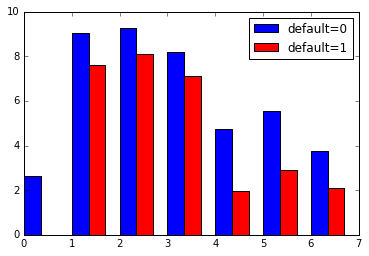

In [24]:
# построим график в логарифмическом масштабе, чтобы были лучше видны различия при разных уровнях образования
pylab.figure(figsize=(12,4))
eds = sorted(data.EDUCATION.unique())
width=0.35
fig, ax = pylab.subplots()

ret = map(lambda x: log(x), data[data.default==0].groupby(by='EDUCATION').count().ID.tolist())
noret = map(lambda x: log(x), data[data.default==1].groupby(by='EDUCATION').count().ID.tolist())
noret.insert(0, 0)

rects1 = ax.bar(eds, ret, width, color='b')
rects2 = ax.bar(np.array(eds) + width, noret, width, color='r')

ax.legend((rects1[0], rects2[0]), ('default=0', 'default=1'))

pylab.show()

In [25]:
# по графику видно, что самая малочисленная группа — доктора (0) — всегда возвращает кредиты
# в группе "нет данных" (6) доля невозвратов заметно выше по сравнению с другими группами

In [26]:
# Проверим, влияет ли уровень образования на то, вернет ли человек долг
# expected_frequences — распределение уровня образования людей, вернувших долг
# observed_frequences — распределение уровня образования людей, невернувших долг
# гипотеза H0 — распределения observed_frequences имеет то же распределение, что и expected_frequences, то есть образование не влияет на то, вернет ли человек долг
# гипотеза H0 — распределения expected_frequences и observed_frequences различны, т.е. образование влияет на то, вернет ли человек долг
expected_frequences = map(lambda x: x, data[data.default==0].groupby(by='EDUCATION').count().ID.tolist())
observed_frequences = map(lambda x: x, data[data.default==1].groupby(by='EDUCATION').count().ID.tolist())
observed_frequences.insert(0, 0)
stats.chisquare(observed_frequences, expected_frequences).pvalue

0.0

In [27]:
# p-value равно нуля, значит можно отвергнуть нулевую гипотезу

In [28]:
# 4. Проверьте, как связан семейный статус с индикатором дефолта
data.MARRIAGE.unique()

array([1, 2, 3, 0])

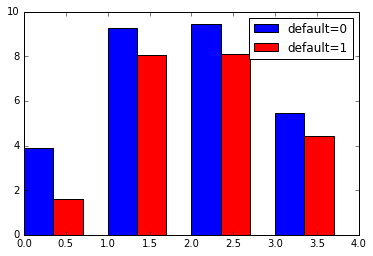

In [29]:
pylab.figure(figsize=(12,4))
eds = sorted(data.MARRIAGE.unique())
width=0.35
fig, ax = pylab.subplots()

ret = map(lambda x: log(x), data[data.default==0].groupby(by='MARRIAGE').count().ID.tolist())
noret = map(lambda x: log(x), data[data.default==1].groupby(by='MARRIAGE').count().ID.tolist())
#noret.insert(0, 0)

rects1 = ax.bar(eds, ret, width, color='b')
rects2 = ax.bar(np.array(eds) + width, noret, width, color='r')

ax.legend((rects1[0], rects2[0]), ('default=0', 'default=1'))

pylab.show()

In [30]:
# по графику можно наблюдать, что доля возвратов кредитов заметно выше в группе, где люди отказались отвечать вопрос о семейном статусе.
# В остальных группах доля возвратов ниже и примерно одинакова между группами
# На мой взгляд, здесь можно использовать бинарное кодирование:
# 1 будет соответствовать ответу либо отсутствию данных о семейном положении:
# 0 — отказу в ответе на этот вопрос
# Проверим, будет ли значимо различие долей при таком кодировании.
# Гипотеза H0 — доля возвратов кредитов одинакова для людей, ответивших/не опрошеных о семейном статусе и людях, отказавшихся отвечать
# Гипотеза H1 — доля возврата кредитов в этих двух выборках различается
# alpha = 0.05
s1 = data[data.MARRIAGE==0].default
s2 = data[data.MARRIAGE!=0].default
proportions_diff_z_test(proportions_diff_z_stat_ind(s1, s2), 'two-sided')

0.022665748122541407

In [31]:
# На уровне значимости 0.05 нулевую гипотезу можно отвергнуть

In [32]:
# 5. a) Гипотеза о равенстве медианных значений возрастов людей пернувших и не вернувших кредит
# H0 медианные значения двух групп равны
# H1 медианные значения двух групп различаются
def0_scores = map(np.median, get_bootstrap_samples(data[data.default==0].AGE.values, 1000))
def1_scores = map(np.median, get_bootstrap_samples(data[data.default==1].AGE.values, 1000))

print "95% confidence interval for default = 0 age:",  stat_intervals(def0_scores, 0.05)
print "95% confidence interval for default = 1 age:",  stat_intervals(def1_scores, 0.05)

95% confidence interval for default = 0 age: [ 34.  34.]
95% confidence interval for default = 1 age: [ 34.  35.]


In [33]:
# доверительные интервалы с уровнем значимости 0.05 пересекаются, что означает что нулевая гипотеза не может быть отвергнута

In [34]:
# b) гипотеза о равенстве распределений 
# гипотеза H0 — средние распределений возраста людей вернувших и не вернувших кредиты равны
# гипотеза H1 — средние распределений этих двух групп не равны
# alpha = 0.05
stats.mannwhitneyu(data[data.default==0].AGE, data[data.default==1].AGE)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.37276989592390031)

In [35]:
# достигаемых уровень значимости больше 0.05, нулевая гипотеза не может быть отвергнута
# на практике это означает, что признак возраста может быть исключен из модели кредитного скоринга для этого набора данных

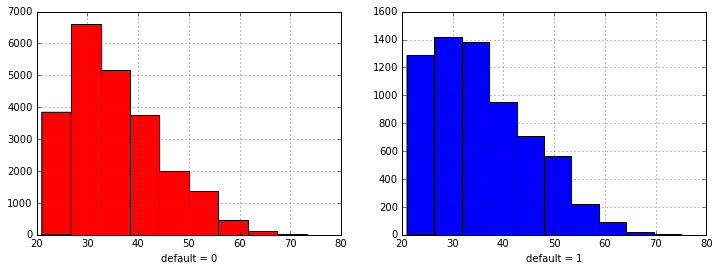

In [36]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(data[data.default==0].AGE, color = 'r')
pylab.xlabel('default = 0')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(data[data.default==1].AGE, color = 'b')
pylab.xlabel('default = 1')

pylab.show()